In [3]:
import polars as pl
import glob
import numpy as np
import matplotlib.pyplot as plt
import logging
import re
import os
from importlib import reload
logging.getLogger('matplotlib.font_manager').disabled = True
from importlib import reload
from datetime import datetime
import pandas as pd



In [4]:
df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/energy_charts2024.csv")

print(df.head(100))

timestring = "2024-01-01T00:00+01:00"

datum = pd.to_datetime(timestring, format="%Y-%m-%dT%H:%M:%S%z", errors='coerce')

# Wenn datum NaT ist, versuche ohne Sekunden
if pd.isna(datum):
    print("test")
    datum = pd.to_datetime(timestring, format="%Y-%m-%dT%H:%M%z", errors='coerce')

print(datum)



shape: (100, 20)
┌─────────────┬────────────┬────────────┬────────────┬───┬────────────┬──────┬────────────┬────────┐
│ Datum (MEZ) ┆ Pumpspeich ┆ Grenzübers ┆ Kernenergi ┆ … ┆ Flüssige   ┆ Wind ┆ Photovolta ┆ Last   │
│ ---         ┆ er         ┆ chreitende ┆ e          ┆   ┆ fossile    ┆ ---  ┆ ik         ┆ ---    │
│ str         ┆ Verbrauch  ┆ r          ┆ ---        ┆   ┆ Energieträ ┆ f64  ┆ ---        ┆ f64    │
│             ┆ ---        ┆ Stromhan…  ┆ f64        ┆   ┆ ger        ┆      ┆ f64        ┆        │
│             ┆ f64        ┆ ---        ┆            ┆   ┆ ---        ┆      ┆            ┆        │
│             ┆            ┆ f64        ┆            ┆   ┆ f64        ┆      ┆            ┆        │
╞═════════════╪════════════╪════════════╪════════════╪═══╪════════════╪══════╪════════════╪════════╡
│ 2024-01-01T ┆ -882.5     ┆ 2549.0     ┆ 2969.6     ┆ … ┆ 0.1        ┆ 43.2 ┆ 0.0        ┆ 8036.2 │
│ 00:00+01:00 ┆            ┆            ┆            ┆   ┆            ┆   

In [5]:

def day_avg_preprocess_season(df, season):
    # Parse the timestamp column
    
    if season == "spring":
        timestamp_range = pl.datetime_range(datetime(2024,3,1), datetime(2024,5,31), "1d",eager=True)
    elif season == "summer":
        timestamp_range = pl.datetime_range(datetime(2024,6,1), datetime(2024,8,31), "1d",eager=True)
    elif season == "autumn":
        timestamp_range = pl.datetime_range(datetime(2024,8,31), datetime(2024,11,30), "1d",eager=True)
    elif season == "all":
        timestamp_range = pl.datetime_range(datetime(2024,1,1), datetime(2024,12,31), "1d",eager=True)
    else:
        timestamp_range = pl.concat([pl.datetime_range(datetime(2024,1,1), datetime(2024,2,28), "1d",eager=True), 
                                     pl.datetime_range(datetime(2024,12,1), datetime(2024,12,31), "1d",eager=True)])
    df = df.with_columns(
        pl.col("Datum (MEZ)").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M%z", strict=False).alias("zeitpunkt_dt")
    )

    timestamp_range = timestamp_range.cast(pl.Date)

    # In your function, ensure the datetime column is cast to Date for comparison
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.date().alias("date_only")
    )

    df = df.filter(
        pl.col("date_only").is_in(timestamp_range.implode())
    )
    
    # Sort by datetime
    df = df.sort("zeitpunkt_dt")
    # Extract time_of_day (hour, minute) as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )

    df = df.with_columns(
        (-pl.col("Grenzüberschreitender Stromhandel") + pl.col("Last")).alias("Summe_zwei_spalten")
    )
    
    sum_cols = ["Pumpspeicher Verbrauch", "Kernenergie", "Abwasser", "Ausleitwasser", "Dotierwasser", 
                "Durchlaufwasser", "Pumpspeicher Erzeugung", "Speicherwasser", "Trinkwasser", "Biogas", "Klärgas", 
                "Holzenergie", "Kehrichtverbrennung", "Gasförmige fossile Energieträger", "Flüssige fossile Energieträger", 
                "Wind", "Photovoltaik"]
    # Group by time_of_day across all days in the range and average the energy column
    day_avg = (
        df.group_by("time_of_day")
            .agg([
                    pl.col("Grenzüberschreitender Stromhandel").mean(),
                    pl.col("Last").mean(),
                    pl.col("Photovoltaik").mean(),
                    sum([pl.col(c) for c in sum_cols]).mean().alias("avg_Summe_Spalten4bis6"),
                    pl.col("Summe_zwei_spalten").mean().alias("Summe"),
                ])
          .sort("time_of_day")
    )
    
    return day_avg

time_avg = day_avg_preprocess_season(df, 'winter')

print(time_avg)

    

shape: (96, 6)
┌─────────────┬────────────────────┬─────────────┬──────────────┬────────────────────┬─────────────┐
│ time_of_day ┆ Grenzüberschreiten ┆ Last        ┆ Photovoltaik ┆ avg_Summe_Spalten4 ┆ Summe       │
│ ---         ┆ der Stromhan…      ┆ ---         ┆ ---          ┆ bis6               ┆ ---         │
│ time        ┆ ---                ┆ f64         ┆ f64          ┆ ---                ┆ f64         │
│             ┆ f64                ┆             ┆              ┆ f64                ┆             │
╞═════════════╪════════════════════╪═════════════╪══════════════╪════════════════════╪═════════════╡
│ 00:00:00    ┆ 1841.315556        ┆ 7175.735556 ┆ 0.0          ┆ 5163.651111        ┆ 5334.42     │
│ 00:15:00    ┆ 1841.315556        ┆ 7175.735556 ┆ 0.0          ┆ 5098.054444        ┆ 5334.42     │
│ 00:30:00    ┆ 1841.315556        ┆ 7175.735556 ┆ 0.0          ┆ 5053.757778        ┆ 5334.42     │
│ 00:45:00    ┆ 1841.315556        ┆ 7175.735556 ┆ 0.0          ┆ 4991.39666

shape: (96, 6)
┌─────────────┬────────────────────┬─────────────┬──────────────┬────────────────────┬─────────────┐
│ time_of_day ┆ Grenzüberschreiten ┆ Last        ┆ Photovoltaik ┆ avg_Summe_Spalten4 ┆ Summe       │
│ ---         ┆ der Stromhan…      ┆ ---         ┆ ---          ┆ bis6               ┆ ---         │
│ time        ┆ ---                ┆ f64         ┆ f64          ┆ ---                ┆ f64         │
│             ┆ f64                ┆             ┆              ┆ f64                ┆             │
╞═════════════╪════════════════════╪═════════════╪══════════════╪════════════════════╪═════════════╡
│ 00:00:00    ┆ 1841.315556        ┆ 7175.735556 ┆ 0.0          ┆ 5163.651111        ┆ 5334.42     │
│ 00:15:00    ┆ 1841.315556        ┆ 7175.735556 ┆ 0.0          ┆ 5098.054444        ┆ 5334.42     │
│ 00:30:00    ┆ 1841.315556        ┆ 7175.735556 ┆ 0.0          ┆ 5053.757778        ┆ 5334.42     │
│ 00:45:00    ┆ 1841.315556        ┆ 7175.735556 ┆ 0.0          ┆ 4991.39666

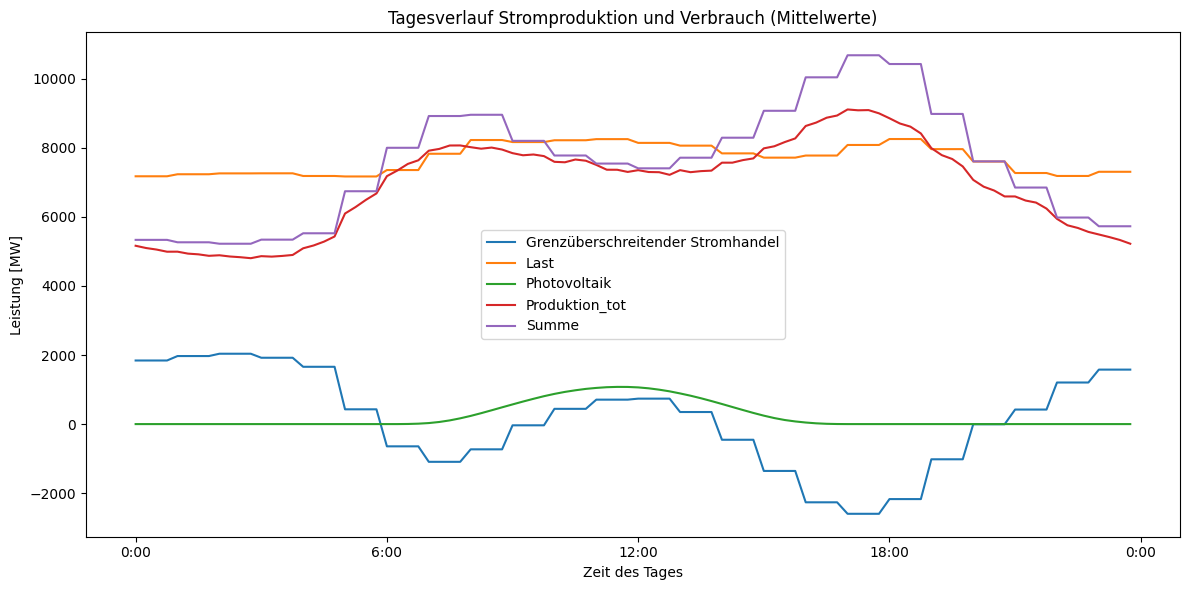

In [6]:
print(time_avg)

pd_time_avg = time_avg.to_pandas()

labels = ['0:00','6:00','12:00','18:00','0:00']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd']

# Zeitachse (= 'time_of_day') als x-Achse übernehmen und alle drei Werte plotten:
plt.figure(figsize=(12,6))
plt.plot(range(1,97), pd_time_avg['Grenzüberschreitender Stromhandel'], label='Grenzüberschreitender Stromhandel', color=colors[0])
plt.plot(range(1,97), pd_time_avg['Last'], label='Last', color=colors[1])
plt.plot(range(1,97), pd_time_avg['Photovoltaik'], label='Photovoltaik', color=colors[2])
plt.plot(range(1,97), pd_time_avg['avg_Summe_Spalten4bis6'], label='Produktion_tot', color=colors[3])
plt.plot(range(1,97), pd_time_avg['Summe'], label='Summe', color=colors[4])
plt.xlabel("Zeit des Tages")
plt.ylabel("Leistung [MW]")
plt.title("Tagesverlauf Stromproduktion und Verbrauch (Mittelwerte)")
plt.legend()
#plt.ylim(0,2000000)
plt.xticks(range(1,120,24),labels=labels)
plt.tight_layout()
plt.show()